<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 9 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 11 March 2020, with material by Cam Davidson-Pilon, Max Margenot, and Thomas Wiecki</div>


# Bayesian methods for determining model parameters

In this notebook, we introduce Bayesian methodology by seeing how **posteriors** are affected by **priors** and **data likelhood**. We then use a Bayesian probabilistic programming library, `PyMC3`, to infer model parameters, which are probability distributions themselves according to Bayesian thinking. 

Their **means** give you the *most probable* values of the parameters, while their **standard deviations** tell you how much of a *mistake* you might be making in assuming each model parameter as the *mean* of its distribution. 

With this information in hand, you can both use the model to generate simulated data *and also* have an idea of how much of a mistake you are making in the simulation. No need for p-values.

Bayesian methodology is very similar to genetic algorithms. But instead of roulette wheel selection, crossover and mutation, Bayesian methods posit a **model**, then leverage Bayes' formula to refine probabilities of model parameters given new data (which ***warps*** model parameter state space), then navigate state space by visiting regions of higher posterior probability unitl convergence. That's *Metropolis*, we'll look into this algorithm, soon.

It's almost like solving a Rubik's cube. You build a **model** for how you think the solution (or getting to the solution) should look, then you try to get closer and closer to it, sometimes probabilistically because you have no idea about the theory behind it..

<br />
<center>
<img src="ipynb.images/rubik.gif" width=400 />
</center>

# 1. The Bayesian expectation fabric

When we create a model with $N$ parameters that we want to solve with Baeysian inference, we are implicitly creating an $N$ dimensional space for the **prior** distribution of *each* paramater to live in. 

Associated with the space is an ***extra dimension***, which we can describe as the *surface*, or *manifold*, that sits on top of the space, that reflects the *probability* of observing data. The surface on the space is defined by our **prior** distribution and *warped* by the **data likelihood**. I call this fabric the **Bayesian expectation fabric**.

So far we've worked in one dimension (one independent variable). Let's move to two dimensions.

For example, if we have two unknown probability distributions $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing the concept that *every point is equally likely*). 

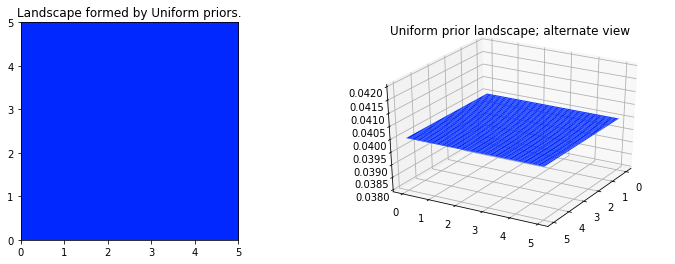

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");


Alternatively, if the two priors are exponentials, for example $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a **water-fall** that emerges at the point (0,0) and flows over the positive numbers. Do you want to see what this looks like? I do.

The plots below visualize this. The more dark-red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue assign very low probability to that location. 

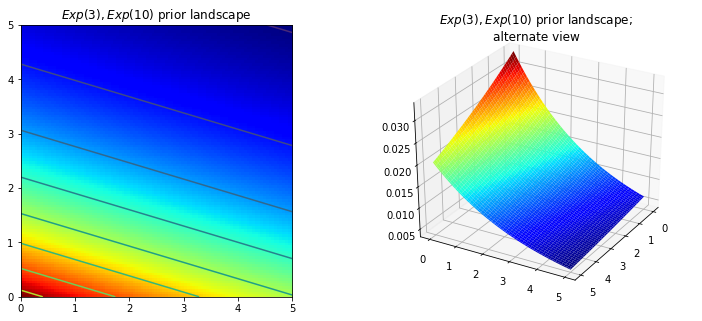

In [2]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");


These are simple examples in 2D space, where our brains can understand the concept of surfaces well. In practice, spaces and surfaces generated by our priors are much higher dimensional and *difficult* to [grok](https://en.wikipedia.org/wiki/Grok).

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space ***after we incorporate our observed data*** $X$? 

The data $X$ changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape (the *prior* shape) is more present.  Regardless, the resulting surface describes the *posterior distribution*. 

>**ANALOGY**: Probabilities allowed me to talk about quantum physics with you. Now Bayesian estimation will let me talk about Einstein's general relativity: Evidence warps the space of prior distributions much in the same way that planterary bodies warp space and create the force of gravity through geometry! Only that Bayesian estimation creates mountains instead of the valleys of planetary bodies :-)

</br >
<center>
<img src="ipynb.images/spacetime-curvature.png" width=400 />
    Spacetime curvature gives rise to gravity
</center>

For two dimensions, in the *opposite* of gravity, data essentially *pushes up* the original data-probability surface to make *tall mountains*. The tendency of observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that *small-in-magnitude prior* probability means *more* resistance. So priors and data likelhihood compete against each other, the same way your mind competes against two thoughts, what you thought before, and what you see now. For example: "*She smokes! I don't like her anymore!*" competes with the prior "*she is so pretty!*"

Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (lower prior probability) near the (5,5) coordinates. Peaks always reflect the posterior probability of where the true parameters are likely to be found. 

>Note that if the prior has assigned a probability of 0, then *no* posterior probability will be assigned there. 0 is a very tricky number in statistics. It means something ***really*** strong. In fact, ***infinitely*** strong.

Suppose the priors mentioned above are associated to two distinct expectation parameters $\lambda$ of two Poisson distributions. Now, let's observe a  datapoint and visualize the ***new*** landscape. This datapoint is a random variate from a 2D Poisson distribution (think about the distribution as the number of emails you receive in one dimension and the number of text messages in the other dimension, per day). This new data is going to change our **prior** beliefs into **posterior** beliefs. It is going to *warp* the Bayesian fabric.

Here is our incoming datapoint:

In [3]:
# create observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we only see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)

data

array([[0, 1]])

In [4]:
data[:, 0]

array([0])

In [5]:
data[:, 1]

array([1])

When you run the cell above you will get different results than me. So let's all start with the same example data I started with. We'll modify this *later on*:

In [6]:
data[:, 0][0] = data[:, 1][0] = 2 

In [7]:
data[:, 0], data[:, 1]

(array([2]), array([2]))

This point belongs to a pdf that is called the **data likelihood** `L`, which in each dimension is the probability density function (actually probability ***mass*** function *pmf* since our random variables are discrete rather than continuous) of the observed *new* data, which stems from a 2D Poisson distribution, with expectation equal to the datapoint we observe: `(data[:, 0], data[:, 1])` (***not*** the expectation of our priors, which is *different*):

In [8]:
# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])
L

array([[2.45049668e-09, 8.50150670e-08, 2.72029869e-07, ...,
        4.42745293e-06, 4.29689111e-06, 4.16931457e-06],
       [8.50150670e-08, 2.94942722e-06, 9.43753062e-06, ...,
        1.53601598e-04, 1.49072018e-04, 1.44646006e-04],
       [2.72029869e-07, 9.43753062e-06, 3.01980614e-05, ...,
        4.91491969e-04, 4.76998288e-04, 4.62836004e-04],
       ...,
       [4.42745293e-06, 1.53601598e-04, 4.91491969e-04, ...,
        7.99933320e-03, 7.76343966e-03, 7.53293980e-03],
       [4.29689111e-06, 1.49072018e-04, 4.76998288e-04, ...,
        7.76343966e-03, 7.53450242e-03, 7.31079981e-03],
       [4.16931457e-06, 1.44646006e-04, 4.62836004e-04, ...,
        7.53293980e-03, 7.31079981e-03, 7.09373903e-03]])

### Uniform priors

First, let's plot our **priors**: How we think the data *will be* distributed ***before*** we actually observe any data. We start with **uniform** priors:

Text(0.5, 1.0, 'Landscape formed by Uniform priors on $p_1, p_2$.')

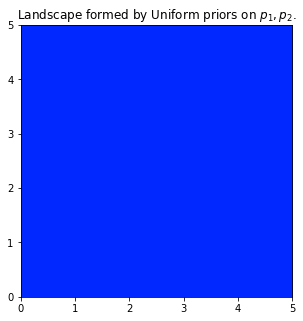

In [9]:
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

And now we suddenly observe a datapoint! 

Our **posterior**, as given by Bayes' formula (we omit the denominator) is: the **data likelihood** `L` times the **prior** `M`. The mountain's peak is the datapoint we observe, because once we observe a datapoint, we expect all other datapoints to appear *at the same location*. We also plot, in yellow, the ***real*** expectation of the data generating mechanism, which we know is a Poisson with expectation (1, 3), and in green the datapoint we observe.

(0, 5)

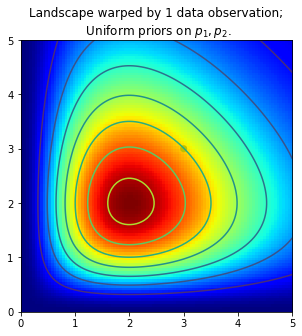

In [10]:
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_2_true, c="y", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

Given the new datapoint, we now expect to observe data coming in with probability contours as pictured above: We expect new data to come in with highest probability exactly where the previous datapoint came in, at `[data[:, 0], data[:, 1]]`.

>**Life in a fish tank**: If you are a fish and your whole life is about observing movement *outside* the aquarium, and your owner comes home every evening from work at 6P, won't you and all the other fish (except the ones asleep) be looking at the front door every evening around 6P, expecting movement at the *exact location y'all saw it yesterday and all other days before*?

### Exponential priors

Now, what if we had started with **exponential** priors instead? In other words, we think there is a ***data fountain*** at the ***origin***, and we expected our data to come from there instead, rather than uniformly. Then our prior surface becomes:

Text(0.5, 1.0, 'Landscape formed by Exponential priors on $p_1, p_2$.')

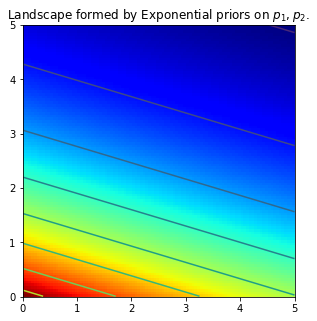

In [11]:
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

That is how we would expect data to flow if it flowed from the origin!

Now, we observe a datapoint! Yay! We're not alone in the universe anymore :-)

How does this datapoint modify our posterior M * L?

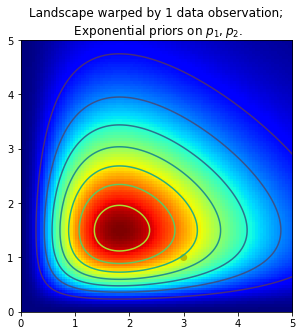

In [12]:
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="y", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

We see that our datapoint created a mountain peak in our expectation fabric, just like before,but more *squished* than before. The top of that mountain is not the datapoint itself anymore `(data[:,0][0], data[:,1][0])` because our prior was a data fountain at the origin. The prior belief *fights* with the new datapoint (from the data likelihood pdf) and the result of that tectonic shift is the landscape you see pictured above.

Let's bring this all together into a *combined* plot, and introduce more datapoints! Like playing God with the tectonic plates on earth! 

We color in `red` our new datapoints and in `green` the expectation which is nothing more than the $\lambda$s of our Poissons. You should be able to see that as you increase the number of datapoints, your posterior gets tighter and tighter (and taller and taller) and the peak gets closer and closer to the theoretical expecation, which is where the green point lies.

The *more* data we observe (from a theoretical Poission distribution will well know Expectation), the *tighter and tighter* our mountain centered around that expectation. We've already seen this phenomenon with coin tosses!

[[0 2]]


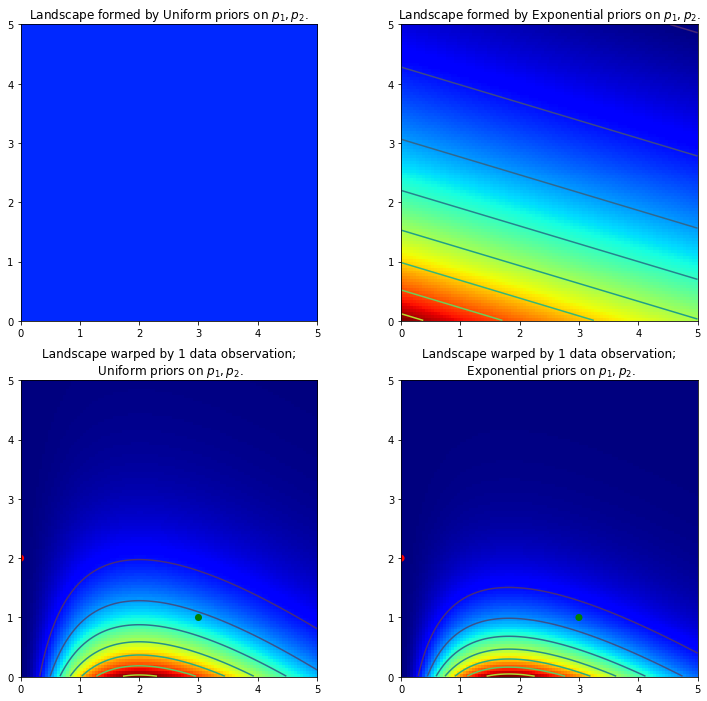

In [13]:
#
# create observed data
#

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print(data)

#
# Likelihood function fron the observed data
#

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

#
# plots
#

figsize(12.5, 12)
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="g", s=50, edgecolor="none")
for _ in range(N):
    plt.scatter(data[_][0], data[_][1], c="r", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="g", s=50, edgecolor="none")
for _ in range(N):
    plt.scatter(data[_][0], data[_][1], c="r", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


The highest points on the mountain, corresponding the the darkest red, are biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The green dot represents the true parameters, or **expectation**, and ***as we increase the number of datapoints, our mountain peak gets closer and closer to the expectation***.

Try changing the sample size to other values (try 5, 10, 100) and observe how the mountain posterior changes.

That is the essence of Bayesian dynamics.

Here is an example of a probabilistic surface that represents surfaces that ML algorithms try to explore:

<br />
<center>
<img src="ipynb.images/the-gradient.png" width=400 />
</center>

Read about it [here](https://www.zdnet.com/article/ai-pioneer-sejnowski-says-its-all-about-the-gradient/).

## 2. Exploring the expectation fabric using PyMC3

Exploring the deformed posterior space generated by our prior surface and observed data is a great exercise. However, we cannot naively search the space: Traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ ([the curse of dimensionality](http://en.wikipedia.org/wiki/Curse_of_dimensionality)).

How do we find these hidden mountains? The idea behind Markov Chain Monte Carlo algorithms is to perform an ***intelligent search*** of the space.

MCMC algorithms like **Metropolis** return **samples** from the posterior distribution, not the distribution itself. 

MCMC performs a task similar to repeatedly asking "*How likely is this pebble I found to be from the mountain I am searching for*?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain. In MCMC and PyMC3 lingo, the returned sequence of "*pebbles*" are the **samples**, cumulatively called the **traces**. 

MCMC does this by exploring nearby positions and moving into areas with higher probability, picking up samples from that area.

### Why do we pick up thousands of samples?

At first, returning thousands of samples might sound like an inefficient way to describe the posterior distributions. 

But.. what other possibilities do we have?

- Returning a mathematical formula for the *mountain ranges* would involve describing a N-dimensional surface with arbitrary peaks and valleys. I don't really know how to do that. Do you? If you do, please tell me!

- Returning the *peak* of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the *shape* of the landscape, which  is ***very important*** in determining posterior confidence in unknowns. 

Besides computational reasons, the strongest reason for returning samples is that we can easily use **the Law of Large Numbers** to solve otherwise intractable problems: With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram, much like you were easily able to generate fake data when I gave you a histogram.


### MCMC algorithms

There is a large family of algorithms that perform MCMC, not just Metropolis. Most of these algorithms can be expressed at a high level as follows:

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4.  1.  If you accept: Move to the new position. Return to Step 1.
    2. Else: Do not move to new position. Return to Step 1. 
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards regions where the posterior distributions live, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution. 

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions *that are likely not from the posterior* but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior. That is why we often *throw away* the first samples.

In the above algorithm, notice that only the current position matters (new positions are investigated only near the current position). This property as *memorylessness*, i.e. the algorithm does not care *how* it arrived at its current position, only that it is there. That is why the chain is **Markovian**.

### Other approximation solutions to the posterior

Besides MCMC, there are other procedures available for determining the posterior distributions. [Gaussian Processes](https://en.wikipedia.org/wiki/Generalized_linear_model) (GPs) are infinite-dimensional generalization of multivariate normal distributions. A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information. Another method is [Variational Bayes](http://en.wikipedia.org/wiki/Variational_Bayesian_methods). All three methods, GPs, Variational Bayes, and classical MCMC have their pros and cons.

# 3. Lab: Unsupervised Clustering using a Mixture Model


Suppose we are given the following dataset:

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


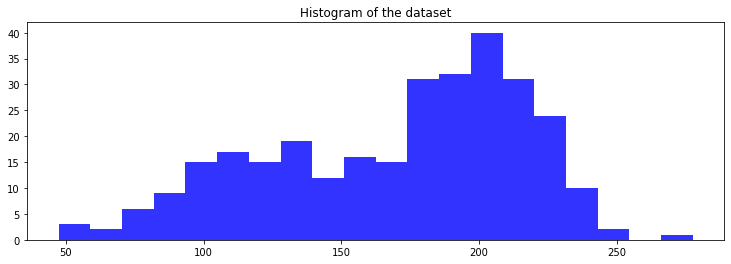

In [19]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="b", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")


In [20]:
data.shape

(300,)

What does the data suggest? It appears the data has a **bimodal** form, that is, it appears to have ***two peaks***, one near 120 and the other near 200. Perhaps there are *two clusters* within this dataset. 

Do you know of a good analytic function that has two peaks? I don't. So, let's assume it comes from ***mixing two analytic functions***, each with their own peak. Like good data scientists, we start with normal distributions. Why? Because it generates 可爱极了 data! Let's try the following generative technique:

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2. 
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

This algorithm would create a similar effect as the observed dataset, so ***we choose this as our model***. This is the ***art*** of data science. Now we're ready for the ***science*** of data science: Finding the right parameters (but wait, there's still a bit of art there too, since we have to guess good pdfs for the parameters as well!).

We do not know $p$ or the parameters of the Normal distributions. So we must infer, or *learn*, these unknowns. This is what Bayesian MCMC programms allow us to do.

*Ready*?

Denote the Normal distributions $\text{N}_0$ and $\text{N}_1$. Both currently have *unknown* **mean** and **standard deviation**, denoted $\mu_i$ and $\sigma_i, \; i =0,1$ respectively. A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$, to $\text{N}_1$ with probability $1-p$.

An appropriate way to assign data points to clusters is to use a PyMC3 `Categorical` stochastic variable. Its parameter is a $k$-long array of probabilities that must sum to one and its `value` attribute is an integer between 0 and $k-1$, randomly chosen according to the crafted array of probabilities (in our case $k=2$). 

*A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$. The probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$. Note we should not use a normal variable, because that presupposes an expectation of 0.5, however in this case we ***have no expectation*** for each datapoint!

Unfortunately, we can't we just give `[p1, p2]` to our `Categorical` variable. PyMC3 uses `Theano` under the hood to build the models so we need to use `theano.tensor.stack()` to combine $p_1$ and $p_2$ into a vector that it can understand. We pass this vector into the `Categorical` variable as well as the `testval` parameter to give our variable an idea of where to start from: 300 random `0`s and `1`s for each of our 300 datapoints, indicating they belong to either cluster 0 or cluster 1.

In [21]:
data.shape[0]

300

Since we have 300 datapoints, we assign each point randomly to either cluster 0 or cluster 1. `assignment` is a **Categorical** probabilistic variable of shape (300,) that takes the values 0 and 1. The `testval` argument is just for debugging.

In [22]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    
    # this produces worse results. Why? This looks like a categorical assignment with Bernoulli probability
    #assignment = pm.Categorical('assignment', np.array([0.5, 0.5]), 
    #                            shape = data.shape[0],
    #                            testval = np.random.randint(0, 2, data.shape[0]))
    
    # This is better: This looks like a categorical assignment with Dirichlet probabilty 
    assignment = pm.Categorical("assignment", p, 
                                shape = data.shape[0],
                                testval = np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:100])

prior assignment, with p = 0.50:
[0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0
 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0
 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1]


Now let's guess the probability distribution for our model parameters!

Looking at my dataset histogram, I would guess that the standard deviations of the two Normal distributions representing each cluster are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Notice that we specified `shape=2`: we are modeling both $\sigma$s as a *single* PyMC3 variable. Note that this does not induce a necessary relationship between the two $\sigma$s, it is simply for succinctness. You could have picked two different variables.

We also need to specify priors on the *centers* of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution because, looking at the data, I have somewhat of an idea where the two centers might be &mdash; I would guess somewhere around 120 and 190 respectively, though I am not very confident in these eyeballed estimates. Hence I will set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

I will also assign a **deterministic** (the opposite of probabilistic) variable to each **probabilistic** `sds` and `centers` variable.

Let's do all this!

- `sds` is a Uniform distribution in \[0, 100\], in 2 dimensions (of shape 2)
- `centers` is a Normal distribution with mean 120 and standard deviation 10 in one dimension, and mean 120 and standard deviation 10 in the other dimension
- `center_i` is a (deterministic) array of **values** that changes with each `assignment` variable. When assignment is = 0, it denotes `centers[0]`, and when assignment is = 1, it denotes `centers[1]`. So the length of `center_i` is 300
- `sd_i` is a (deterministic) array of **values** that changes with each `assignment` variable. When assignment is = 0, it denotes `sds[0]`, and when assignment is = 1, it denotes `sds[1]`. So the length of `sd_i` is 300
- `observations` is a probabilistic Normal distribution that ***fits*** the observed `data`, with mean and standard deviation that changes for each datapoint in `data`. So sometimes it's `centers[0]` and `sds[0]`, and other times it's `centers[1]` and `sds[1]`, depending on the `assignment` value of each datapoint

In [23]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:100], "...")
print("Assigned center: ", center_i.tag.test_value[:100], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:100])

Random assignments:  [0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0
 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0
 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1] ...
Assigned center:  [120. 190. 190. 190. 120. 190. 190. 120. 190. 190. 190. 120. 190. 190.
 120. 120. 190. 190. 190. 190. 190. 190. 190. 120. 120. 120. 190. 120.
 120. 120. 120. 190. 190. 190. 120. 190. 120. 190. 190. 120. 120. 120.
 120. 190. 190. 190. 120. 190. 120. 190. 120. 190. 120. 120. 190. 120.
 190. 120. 120. 190. 120. 120. 190. 190. 190. 190. 190. 190. 120. 120.
 120. 190. 190. 120. 190. 190. 190. 190. 120. 190. 120. 190. 120. 120.
 190. 120. 190. 190. 190. 120. 120. 120. 190. 190. 190. 120. 190. 190.
 120. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.

So that is what we start with: random assignments for each datapoint.

Notice how we continue to build the model within the context of `Model()`. This automatically adds the variables that we create to our model. As long as we work within this context we will be working with the same variables that we have already defined. Any sampling that we do within the context of `Model()` will be done only on the model in which we are working. 

We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `ElemwiseCategorical()` for our categorical variable (Metropolis does not work for discrete variables).

We will use these sampling methods to explore the space by using `sample(iterations, step)`, where `iterations` is the number of steps we wish the algorithm to perform and `step` is the way in which we want to handle those steps. 

We use our combination of `Metropolis()` and `ElemwiseCategorical()` for the `step` and sample 25,000 iterations:

>**Important to understand (repeat this 10 times)**: We *sample* from the posterior at every time step of our iteration, and this gives us different samples of all our model paramters. At each time step we get closer and closer to pdfs for our model parameters (`mu` and `sd`) that yield the data likelihood `observations` pdf which fits our empirical histogram the best. So when we converge, we have the exact modeling solution for our empirical data as model **distributions**, yeilding best point approximations as well as errors made (standard deviation).

>**NOTE**: We are going *back in time* to find the process that generated the data.

This simulation will run much *slower* that what you might be used to. This model is *complex*! Don't run it now. Better: Run it now and follow me on *my* notebook.

In [24]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

C:\Users\liaoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 102000/102000 [1:39:04<00:00, 17.16draws/s]
The number of effective samples is smaller than 10% for some parameters.


We have stored the paths of all our variables, or **traces**, in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far in our exploration of our state space.

The individual path of each variable is indexed by the PyMC3 variable `name` that we gave that variable when defining it within our model. For example, `trace["sds"]` will return a `numpy array` object that we can then index and slice as we would any other `numpy array` object. 

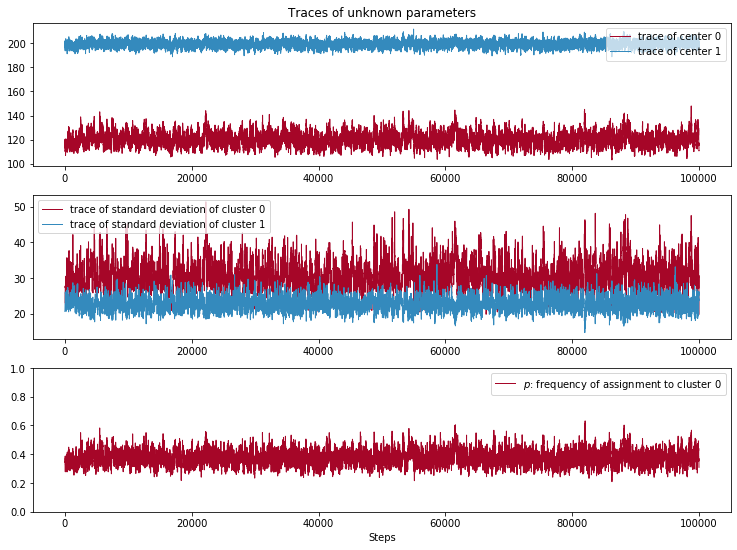

In [25]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# pretty colors
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


Notice the following characteristics:

1. The traces converge, not to a single point, but to a *distribution* of possible points. This is *convergence* in an MCMC algorithm!
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the *burn-in period*.
3. The traces appear as a *random walk* around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section later below.

To achieve further convergence, we will perform *more* MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the `trace` object. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off. 

We will sample the MCMC ***fifty thousand*** *more* times and visualize progress below:

In [ ]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains, 0 divergences:  42%|██████████████▍                   | 85754/202000 [1:34:53<1:46:29, 18.19draws/s]

In [ ]:
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]
center_trace.shape

In [ ]:
center_trace[:,1].shape

In [ ]:
figsize(12.5, 4)

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:50000, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:50000, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");


### Cluster Investigation

Our main challenge is to identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

In [ ]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. The most likely standard deviation is 50 for cluster 0, and 22 for cluster 1.

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0. 

In [ ]:
import matplotlib as mpl
figsize(10, 10)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");


Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point). A more clear diagram is below, where we estimate the *frequency* of each data point belonging to labels 0 and 1:

In [ ]:
figsize(10, 5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");


Even though we modeled the clusters using Normal distributions, we didn't get just two Normal distributions that *best* fit the data, but a distribution of values for the Normal distributions' parameters. 

>Repeat this twice more, because it's *key* to Bayesian estimation.

Now, how can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian? 

One quick way is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

In [ ]:
trace["p"].mean()

In [ ]:
norm = stats.norm
figsize(15, 5)
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


### Important: Don't mix posterior samples

In the above example, a possible (though less likely) scenario is that cluster 0 has a very large standard deviation, and cluster 1 has a small standard deviation. This would still satisfy the evidence, albeit less so than our original inference. Alternatively, it would be incredibly unlikely for *both* distributions to have a small standard deviation, as the data does not support this hypothesis at all. Thus the two standard deviations are *dependent* on each other: if one is small, the other must be large. In fact, *all* the unknowns are related in a similar manner. For example, if a standard deviation is large, the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area. 

During MCMC, we are returned vectors representing samples from the unknown posteriors. Elements of different vectors cannot be used together, as this would break the above logic: perhaps a sample has returned that cluster 1 has a small standard deviation, hence all the other variables in that sample would incorporate that and be adjusted accordingly. It is easy to avoid this problem though, just make sure you are indexing traces correctly. 

Another small example to illustrate the point. Suppose two variables, $x$ and $y$, are related by $x+y=10$. We model $x$ as a Normal random variable with mean 4 and explore 500 samples.  

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");


As you can see, the two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i = j$.

### Returning to Clustering: Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots. 

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method. 

We will use Bayes Theorem for this:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "*is the probability that $x$ is in cluster 1 **greater** than the probability it is in cluster 0*?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \;\;\;? \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) } \;\;\;?
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) \;\;\;?$$

Let's write this equation down probabilistically, and look at its mean to get the most realistic estimate:

In [ ]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0


### Using `MAP` to improve convergence

If you rerun the sims you may notice that our results are not consistent: Perhaps your initial cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm. 

It can be shown, mathematically, that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not *fully converged yet*, and we should not use samples from it yet (we should use a larger burn-in period).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the peak, we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this *peak* the [maximum a posterior](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC3 provides a function that will approximate, if not find, the MAP location. In the PyMC3 main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. 

The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. 

As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/) [1], by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. 

The default works well enough, but if convergence is slow or not guaranteed, you can experiment with Powell's method or the other algorithms available. 

The MAP can also be used as a solution to the inference problem, as mathematically it is the *most likely* value for the unknowns. But as mentioned earlier, this location ignores the uncertainty and doesn't return a distribution.

>**Update**: In the later versions of the Hamiltonian algorithms (the defaults) of PyMC3, you do not need to use `pm.find_MAP()` anymore.


### Convergence is wickedly affected by your choice of priors

If you try the commented out option for priors in cell \[44\] (`categorical assignment with Bernoulli probability`), you will get results that are worse, underscoring how important it is to pick good priors. Categorical assignments with [Diriclet probability](https://en.wikipedia.org/wiki/Dirichlet_process) usually works out better than categorical assignments with Bernoulli probabilities. This has something to do with the [Chinese restaurant process](https://en.wikipedia.org/wiki/Chinese_restaurant_process), but the basic reason why still eludes me..


### Burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. It is easy enough to simply discard the beginning section of the trace just through array slicing. 

As one does not know when the chain has fully converged, a good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. To continue the clustering example from above, the new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]


## Diagnosing Convergence

### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1.0 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_\tau$, at time $t$ is with the series at time $t-k$:

$$R(k) = Corr( x_t, x_{t-k} ) $$

>If the series is autocorrelated, you *can predict it*. If not, *you cannot*!

For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:

In [ ]:
figsize(12.5, 4)

import pymc3 as pm
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();


One way to think of autocorrelation is "*if I know the position of the series at time $s$, can it help me know where I am at time $t$*?" In the series $x_t$, the answer is ***No***. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? ***No***.

On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to it's logical conclusion, we must concede that as $k$, the lag between time points, increases, the autocorrelation decreases. We can visualize this:

In [ ]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");


Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (***which it really is***), hence we can conclude no autocorrelation exists in this series. 


### How does this relate to MCMC convergence?

By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step `from your current position, move to a position near you`).

A chain that is ***not*** exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is ***not necessary*** for convergence, but it is ***sufficient***.

>***If*** you observe low autocorrelation, your chain has converged. 

PyMC3 has a built-in autocorrelation plotting function in the `plots` module. 

### Thinning

Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be *independent* of each other. This can be solved, or at least reduced, by only returning to the user every $n$th sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$ with differing levels of **thinning**:

In [ ]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");


With more thinning, the autocorrelation drops quicker. There is a tradeoff though: higher thinning requires more MCMC iterations to achieve the same number of returned samples. For example, 10 000 samples unthinned is 100 000 with a thinning of 10 (though the latter has less autocorrelation). 

What is a good amount of thinning? The returned samples will always exhibit some autocorrelation, regardless of how much thinning is done. So long as the autocorrelation tends to zero, you are probably ok. Typically thinning of more than 10 is not necessary.

Artificial Neural Network algorithms have a simliar concept, called **minibatch**:
- If one updates model parameters after processing the whole training data (i.e., epoch), it would take too long to get a model update in training, and the entire training data probably won’t fit in the memory.
- If one updates model parameters after processing every instance (i.e., stochastic gradient descent), model updates would be too noisy, and the process is not computationally efficient.
- Therefore, minibatch gradient descent is introduced as a trade-off between {fast model updates, memory efficiency} and {accurate model updates, computational efficiency}.

### `pymc3.plots`

It is not necessary to manually create histograms, autocorrelation plots and trace plots each time we perform MCMC. The authors of PyMC3 have included a visualization tool for just this purpose. 

The `pymc3.plots` module contains a few different plotting functions that you might find useful. For each different plotting function contained therein, you simply pass a `trace` returned from sampling as well as a list, `varnames`, of the variables that you are interested in. This module can provide you with plots of autocorrelation and the posterior distributions of each variable and their traces, among others.

Below we use the tool to plot the centers of the clusters.

In [ ]:
pm.plots.traceplot(trace, varnames=["centers"])
pm.plots.plot_posterior(trace["centers"][:,0])
pm.plots.plot_posterior(trace["centers"][:,1])
pm.plots.autocorrplot(trace, varnames=["centers"]);

The first plotting function gives us the posterior density of each unknown in the `centers` variable as well as the `trace` of each. `trace` plot is useful for inspecting that possible "*meandering*" property that is a result of non-convergence. The density plot gives us an idea of the shape of the distribution of each unknown, but it is better to look at each of them individually.

The second plotting function(s) provides us with a histogram of our model parameter samples with a few added features:
- The text overlay in the center shows us the posterior mean, which is a good summary of posterior distribution. 
- The interval marked by the horizontal black line overlay represents the *95% credible interval*, sometimes called the *highest posterior density interval* and not to be confused with a *95% confidence interval* (CI) of frequentist statistics. The *highest posterior density interval* can be interpreted as "*there is a 95% chance the parameter of interest lies in this interval*". When communicating your results to others, it is important to state this interval. 

One of the purposes for studying Bayesian methods is to have a clear understanding of our uncertainty in the model parameters. Combined with the posterior mean (the best "*guess*" for model parameters), the 95% credible interval provides a reliable interval to communicate the likely location of the best guess *and* the uncertainty (represented by the width of the interval).

> The *confidence interval* is a frequentist statistics construct. A confidence level represents the frequency (i.e. the proportion) of possible confidence intervals that contain the true value of the unknown population parameter. In other words, if confidence intervals are constructed using a given confidence level from an infinite number of independent sample statistics (parallel universes), the proportion of those intervals that contain the true value of the parameter will be equal to the confidence level.For example, if the confidence level (CL) is 95% then in hypothetical indefinite data collection, in 95% of the samples the interval estimate will contain the true population parameter. This is not the same as saying "*there is a 95% chance the parameter of interest lies in this interval*", and I much prefer the latter over the former!

The last plots, titled `center_0` and `center_1` are the generated autocorrelation plots, similar to the ones displayed above. Decreasing autocorrelation is a sufficient condition for convergence, so it gives us a good warm fuzzy we achieved convergence.

## Useful tips for MCMC

Bayesian inference would be the *de facto* method if it weren't for MCMC's computational difficulties (especially of the denominator). In fact, MCMC is what turns most users off practical Bayesian inference. Below are some good heuristics  to help convergence and speed up the MCMC engine. This is all part of the *art* of Bayesian estimation.

### Intelligent starting values

It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we *think* the posterior distribution will be by specifying the `testval` parameter in the `Stochastic` variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the $\mu$ parameter, then a good starting value would be the *mean* of the data. 

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )

For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

This is what using `MAP` tries to do, by giving good initial values to the MCMC. So why bother specifying user-defined values? Well, even giving `MAP` good values will help it find the maximum a-posterior. 

Also important, *bad initial values* are a source of major bugs in PyMC3 and can hurt convergence.

### Good Priors

If the priors are poorly chosen, the MCMC algorithm may not converge, or at least have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to *carefully* choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see *Folk Theorem of Statistical Computing* below). 

### Covariance matrices and eliminating parameters

Minimizing the number of parameters in your model and especially parameters that are interdependent is an important consideration. You can use covariance matrices to see if parameters turn out to be very dependent. If so, return to the drawing board and build a lower-dimensional model with statistically independent parameters.

### The Folk Theorem of Statistical Computing

>   *If you are having computational problems Ilike getting many `NaN`s, probably your model is wrong.*


## Homework

The simulations in this notebook take too long to perform in class, so please perform then at home. I *may* email you just a *tad bit more* homework, too.

## Conclusion

PyMC3 provides a very strong backend to performing Bayesian inference, mostly because it has abstracted the inner mechanics of MCMC from the user. But sometimes it's..

<br />
<center>
<img src="ipynb.images/garfield-tired.gif" width=400 />
</center>

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
